In [171]:
import sys
sys.path.append('/home/jupyter/DS_O2_Tools')

from typing import List, Dict
import numpy as np
import pandas as pd
from google.cloud import bigquery
from google.cloud import storage
import decimal
#import math
import matplotlib.pyplot as plt


import seaborn as sns

import os
import json
from tempfile import TemporaryDirectory
from time import time

import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from catboost.utils import get_roc_curve

#from preprocessing import find_column_type, get_ct_feature_names, get_feature_out, custom_RFE, outlier_function_wrapper, evaluate_preprocessors, Transformer_target_encoder_multiclass, detect_features_high_number_nulls, FakeTransformer
from mlops_pipelines.helpers.bigquery import get_schema_from_query_job, bq_schema_to_dtypes

from catboost import CatBoostClassifier, Pool, cv, metrics, EShapCalcType, EFeaturesSelectionAlgorithm, CatBoost

from catboost.utils import get_roc_curve

import shap

In [172]:
#Function from mlops_pipelines does not include "BIGNUMERIC" so defining it here
def bq_schema_to_dtypes(bq_schema: List[Dict[str, str]]) -> Dict[str, str]:
    mapping_dict = {
        "STRING": "str",
        "INTEGER": "int",
        "FLOAT": "float",
        "NUMERIC": "float",
        "BIGNUMERIC": "float",
        "BOOLEAN": "bool",
    }
    return {column["name"]: mapping_dict.get(column["type"], "object") for column in bq_schema}

In [173]:
def find_column_type(df):
    """
    This function identify categorical, boolean and numerical values.

    Parameters
    ---------
    df : DataFrame
        Usually a DataFrame with training samples that will be used to fit a model.

    Returns
    -------
    categorical_cols : list
        Categorical features.
    bool_cols:
        Boolean features.
    numerical_cols:
        Numerical features.
    """
    
    all_cols=list(df.columns)
    numerical_cols_temp = df.select_dtypes('number').columns
    categorical_cols = list(set(all_cols) - set(numerical_cols_temp))
    bool_cols = [col for col in all_cols if np.isin(df[col].dropna().unique(), [0,1,0.0,1.0]).all()]
    numerical_cols = list(set(numerical_cols_temp) - set(bool_cols))
    
    return categorical_cols,bool_cols,numerical_cols

In [174]:
def plot_summary_1df(df1,label1,title,overal_rate=False):

    if overal_rate:
        overal_rate_1=overal_rate
    else:
        overal_rate_1 =(df1['cum_o2extras'].max()/df1['cum_no_of_customers'].max())*100
    
    print(overal_rate_1)
    fig1 = plt.figure(figsize=(9.6, 2.7))
    ax11 = fig1.add_subplot(131)
    ax11.bar(df1['decile'],df1['o2extras_rate'],label=label1)
    ax11.hlines(y=overal_rate_1,xmin=0,xmax=10.5,linestyle='dashed',label = 'overal rate')
    ax11.set_xlim(0,10.5)
    ax11.set_xticks([1,2,3,4,5,6,7,8,9,10])
    ax11.set_xticklabels([1,2,3,4,5,6,7,8,9,10],fontsize=10)
    ax11.set_ylabel('EXTRAS take-up rate (%)')
    ax11.set_xlabel('Decile')
    
    ax11.legend(prop={'size': 6})
    
    ax12 = fig1.add_subplot(132)
    ax12.plot(df1['cum_per_no_of_customers'],df1['lift'],label=label1)
    ax12.plot(df1['cum_per_no_of_customers'],df1['lift'],'o',color='tab:blue',alpha=0.5)
    ax12.hlines(y=1,xmin=0,xmax=100,linestyle='dashed',label='random')
    ax12.set_xlim(0,100)
    ax12.legend(prop={'size': 6})
    ax12.set_ylabel('Lift')
    ax12.set_xlabel('% of customers targeted')

    ax13 = fig1.add_subplot(133)
    ax13.plot(df1['cum_per_no_of_customers'],df1['cum_per_o2extras'],label=label1)
    ax13.plot(range(0,110,10),range(0,110,10),color='black',linestyle='dashed',label='random')
    ax13.set_ylabel('% of EXTRAS')
    ax13.set_xlabel('% of Customers Targeted')
    ax13.legend(prop={'size': 6})
    
    fig1.subplots_adjust(left=None,
    bottom=.2,
    right=None,
    top=None,
    wspace=.4,
    hspace=None)
    

In [175]:
def plot_summary_b(df1,label1,title,overal_rate=False):

    if overal_rate:
        overal_rate_1=overal_rate
    else:
        overal_rate_1 =(df1['cum_o2extras'].max()/df1['cum_no_of_customers'].max())*100
    print(overal_rate_1)
    fig1 = plt.figure(figsize=(18, 5))
    ax11 = fig1.add_subplot(131)
    ax11.bar(df1['decile'],df1['o2extras_rate'],label=label1)
    ax11.hlines(y=overal_rate_1,xmin=0,xmax=10.5,linestyle='dashed',label = 'overal rate')
    ax11.set_xlim(0,10.5)
    ax11.set_xticks([1,2,3,4,5,6,7,8,9,10])
    ax11.set_xticklabels([1,2,3,4,5,6,7,8,9,10],fontsize=10)
    ax11.set_ylabel('EXTRAS take-up rate (%)')
    ax11.set_xlabel('Decile')
    # ax11.set_xlabel('Percentile within the top decile')
    
    ax11.legend(prop={'size': 10})
    
    ax12 = fig1.add_subplot(132)
    ax12.plot(df1['cum_per_no_of_customers'],df1['lift'],label=label1)
    ax12.plot(df1['cum_per_no_of_customers'],df1['lift'],'o',color='tab:blue',alpha=0.5)
    ax12.hlines(y=1,xmin=0,xmax=100,linestyle='dashed',label='random')
    
    ax12.set_xlim(0,100)
    
    # ax12.set_title(title,fontsize=10)
    ax12.legend(prop={'size': 10})



    ax12.set_ylabel('Lift')
    ax12.set_xlabel('% of customers targeted')

    ax13 = fig1.add_subplot(133)
    ax13.plot(df1['cum_per_no_of_customers'],df1['cum_per_o2extras'],label=label1)
    ax13.plot(range(0,110,10),range(0,110,10),color='tab:blue', linestyle='dashed',label='random')
    ax13.set_ylabel('% of EXTRAS')
    ax13.set_xlabel('% of Customers Targeted')
    ax13.legend(prop={'size': 10})
    
    fig1.subplots_adjust(left=None,
    bottom=.2,
    right=None,
    top=None,
    wspace=.4,
    hspace=None)
    plt.savefig('/home/jupyter/o2extras/outputs/summary_plot.png', bbox_inches='tight')
    plt.show()
    
    

In [176]:
pd.set_option("display.max_columns", 1000, "display.max_rows", 1000)

In [177]:
client = bigquery.Client(project="prj-vo-aa-p-data-science-exp", location='europe-west2')

In [178]:

%%bigquery df
select * from prj-vo-aa-p-data-science-exp.jorquec.O2extrasdisneyM4

Query complete after 0.00s: 100% 1/1 [00:00<00:00, 804.12query/s] 
Downloading: 100% 18766/18766 [00:01<00:00, 15154.57rows/s]


In [179]:
EVALUATION_DATASET_SQL='''
select * from prj-vo-aa-p-data-science-exp.jorquec.O2extrasdisneyM4
'''

In [180]:
evaluation_query_job = client.query(EVALUATION_DATASET_SQL)
bq_schema = get_schema_from_query_job(client, evaluation_query_job)

## We make sure the types in the DF are matching the bq schema, we also cast any string to categorical once we load the dataframe
dtypes_dict = bq_schema_to_dtypes(bq_schema)
df = df.astype(dtypes_dict, errors='ignore')

In [181]:
df.head()

,ref_date,CUSTOMER_CAT,usi,cycle,contract_seq_no_adjusted,days_from_ced,contract_start_date,ooc,resign_fanboy_group,channel_l1,sim_only_ind,mins_allowance,term,tenure_months,days_on_current_imei,tenure_desc,time_on_handset,second_hand_imei_hd,age_id_2,new_acorn_cat_desc,familyplan_flag,spend_cap_level,contract_type,refresh,flex_refresh_flag,first_recent_channel,second_recent_channel,third_recent_channel,total_cs_mins,cs_int_flag,digital_int_flag,wc_int_flag,no_of_comms_3m,no_of_comms_6m,assisted_effort_dur,ecn_sent_flag_l1m,o2_wifi_days_last_30,o2_wifi_days_last_90,wifi,device_fanboy_group,subs,offering_subs_rev_inc_vat_amt,pac_request_l1m,credit_band,o2_travel_iz_flag,o2_travel_row_flag,multiple_mpn_flag,os_desc,device_os,iphone,vendor_desc_2,is_o25g_ind,hs_flag,simo_flag,total_isrl_browsing_time_l3m,isrl_browsing_time_cat,domestic_data_costs,avg_dom_data_costs,ch_dom_data_costs,no_of_cells_used,avg_tot_ic_cost,ch_tot_ic_cost,total_interconnect_cost,arpu,airtime_margin,avg_arpu,avg_airtime_margin,ch_arpu,ch_airtime_margin,revenue_amount,ch_billed_revenue,billed_revenue,avg_billed_revenue,c2m_ind,domestic_data_usage,total_voice_mins,total_voice_calls,avg_dom_data_usg,off_net_call_c,avg_offnet_call_c,avg_offnet_call_d,avg_standard_d,avg_standard_c,roam_data_usg,avg_roam_data_usg,avg_onnet_call_c,avg_onnet_call_d,voice_per,sms_per,per_offnet_call_c,per_offnet_call_d,per_onnet_call_d,ch_dom_data_usg,ch_offnet_call_d,ch_onnet_call_d,ch_standard_d,per_standard_d,ch_sms_c,per_sms_c,utilisation_band,utilisation,data_util,standard_d,standard_c,premium_costs,roaming_cost,avg_other_d,avg_sms_c,off_net_call_d,on_net_call_c,on_net_call_d,sms_c,myo2,my_o2_days_access_last_30,my_o2_days_access_last_90,retail_int_flag,online_upgrade_visit_l1m,interconnect_revenue,avg_ic_mob_day_r,avg_ic_natl_r,avg_tot_ic_rev,interconnect_natl_r,avg_ic_mob_eve_r,avg_ic_mob_wkd_r,avg_ic_sms_r,interconnect_mob_day_r,interconnect_sms_r,ch_ic_sms_r,ch_ic_natl_r,total_interconnect_rev,ch_tot_ic_rev,ch_ic_mob_wkd_r,mobile_broadband_ind,device_group_desc,tv_region_desc_2,data_uk_allow_mb_qty,plan_cca_ind,additional_data_allowance_1mth,additional_data_allowance_2mth,additional_data_allowance_3mth,in_bundle_data_usage_1mth,in_bundle_data_usage_2mth,in_bundle_data_usage_3mth,max_snacking_bought_l3m,sharers_ind,free_video_streaming,online_competitor_visit_l3m,age_grp_2,load_date,online_competitor_visit_l1m,handset_price,insurance,opted_in_flag,ported_from_grp,ported_flag,simo_subscr_ids,handset_subscr_ids,tenure_dt,total_sms_1st_5days,total_voice_count_1st_5days,total_voice_duration_1st_5days,total_data_usage_1st_5days,total_subscr_ids,no_of_current_connections,arrears,j6_total_duration_90,j7_total_duration_90,total_voice_count,domestic_voice_duration,comms_engaged_with,comms_delivered,tech_tariff,o2_4g_sig_strength_at_PC,total_assist_duration_90,device_screen,device_price,pac_requested_l12m,main_data_bolton_allowance,early_life,contract_month,bt_overbuild,alt_net_overbuild,target,eff_from_timestamp,eff_to_timestamp,product_id,product_type_1,product_type_2,perk_type1,product_name,perk_type2,perk_type2_later,extra_interactionjourney_30firstdays,extra_interactionbrow_duration_last30,extra_interactionbrow_duration_last60,extra_interactionbrow_duration_last90,extra_interactionbrow_duration_last120,extra_interactionbrow_duration_last150,extra_interactionbrow_duration_last180,acorn_group,acorn_type,gender_desc,broadband_provider_email,ave_ncx_l3m,ncx_days_0to20_l3m,ncx_days_20to40_l3m,ncx_days_40to60_l3m,ncx_days_60to80_l3m,ncx_days_80to100_l3m,ncx_score,final_data_allowance
0,2023-03-31,UPGRADE,-956689181,5.0,5.0,0,2023-03-01,0,INC 0-1months,Online,0,45000.0,1,156,28.0,over 60mths,28.0,0,NaN,None,0,None,Handset Refresh,0.0,0,Online,Online,None,0.0,0.0,1.0,0.0,24.0,31.0,0.0,0.0,0.0,0.0,1.0,Existing Other Android,31.99,31.99,NaN,NaN,NaN,NaN,0.0,OSx,iOS,1.0,APPLE,0.0,0.0,0.0,0.0,No browsing,437.726996,146.518553,2.987519,235.0,-1.844633,2.219520,-4.0942,299.4205,307.5210,126.11

In [182]:
df.shape

(18766, 211)

In [183]:
df.target.value_counts()

0    17570
1     1196
Name: target, dtype: int64

In [11]:
# To load Preprocessed file WITHOUT usi ( I will not use in this notebook)
#  pre processed previously in notebook '4_model_test_evaluation_beforetunning-v3.ipynb'
# dfpre_nousi = pd.read_pickle('gs://jorquec_bucket/o2extras/o2extradataset_eval_preprocessed.pickle')

## Preprocessing evaluation dataset ( keeping usi column)

In [184]:
## Drop date and timestamp columns

df.drop(["ref_date",
         "contract_start_date", 
         "eff_from_timestamp",
         "eff_to_timestamp",
         "load_date",
         "tenure_dt",
         "acorn_type",
         "new_acorn_cat_desc", 
         "perk_type1",
         "perk_type2_later",
         "perk_type2",
         "product_id",
         "product_type_1",
         "product_type_2",
         "product_name",
         "online_competitor_visit_l1m",
         "online_competitor_visit_l3m", "o2_4g_sig_strength_at_PC",
         "device_screen","device_price","sharers_ind",
         "free_video_streaming","second_hand_imei_hd",
         "CUSTOMER_CAT","tech_tariff"                          
         ], axis = 1, inplace=True)

In [185]:
df.drop(['familyplan_flag',
                'total_cs_mins',
                'assisted_effort_dur',
                'o2_wifi_days_last_30',
                'o2_wifi_days_last_90',
                'o2_travel_iz_flag',
                'c2m_ind',
                'per_standard_d',
                'standard_d',
                'myo2',
                'my_o2_days_access_last_30',
                'my_o2_days_access_last_90',
                'additional_data_allowance_1mth',
                'additional_data_allowance_2mth',
                'additional_data_allowance_3mth',
                'standard_c',
                'is_o25g_ind',
                'o2_travel_row_flag',
                'max_snacking_bought_l3m',
                'avg_standard_d',
                 'avg_standard_c',
                 'ch_standard_d',
                 'premium_costs',
                 'avg_other_d',
                 'online_upgrade_visit_l1m',
                 'interconnect_revenue',
                 'avg_ic_mob_day_r',
                 'avg_ic_mob_eve_r',
                 'avg_ic_mob_wkd_r',
                 'interconnect_mob_day_r',
                 'ch_ic_mob_wkd_r',
                 'ncx_days_20to40_l3m'               
          ], axis = 1, inplace=True)

In [186]:
#  list subset of 100% correlated features to be dropped

df.drop(['contract_seq_no_adjusted','j7_total_duration_90','utilisation','offering_subs_rev_inc_vat_amt',
        'contract_month','days_on_current_imei','voice_per'], axis = 1, inplace=True)

In [187]:
categorical_cols, bool_cols, numerical_cols = find_column_type(df)

In [188]:
#to remove the whitespace from the beginning and at the end of the string
for col in categorical_cols:
    df[col] = df[col].str.strip()

In [189]:
# This is needed because unexpectedly the way the data is read from bigquery using the mlops pipeline functions
# infer null strings as 'None' (string). Reading it directly from bigquery in a notebook you get the expected
# None though, so it must be something to do in the way they read it in the pipeline.

df = df.replace(to_replace=['None'], value = np.nan)


In [190]:
df = df.replace(to_replace=['NONE'], value = np.nan)

In [191]:
df["utilisation_band"].replace(np.nan,"H. Unkno",inplace=True)
df["isrl_browsing_time_cat"].replace(np.nan,"No browsing",inplace=True)
df["broadband_provider_email"].replace(np.nan,"other",inplace=True)
df["device_fanboy_group"].replace(np.nan,"unknown",inplace=True)
df["resign_fanboy_group"].replace(np.nan,"unknown",inplace=True)
df["gender_desc"].replace(np.nan,"Unknown",inplace=True)
df["tenure_desc"].replace(np.nan,"unknown",inplace=True)
df["device_group_desc"].replace(np.nan,"Unknown",inplace=True)
df["os_desc"].replace(np.nan,"Other",inplace=True)
df["age_grp_2"].replace(np.nan,"f. Unknown",inplace=True)
df["channel_l1"].replace(np.nan,"Other",inplace=True)
df["channel_l1"].replace("Null","Other",inplace=True)
df["acorn_group"].replace(np.nan,"Unknown",inplace=True)
df["vendor_desc_2"].replace(np.nan,"OTHER",inplace=True)
##df["new_acorn_cat_desc"].replace(np.nan,"unknown",inplace=True)
df["tv_region_desc_2"].replace(np.nan,"Unknown",inplace=True)
df["first_recent_channel"].replace(np.nan,"Other",inplace=True)
df["first_recent_channel"].replace("Null","Other",inplace=True)
df["second_recent_channel"].replace(np.nan,"Other",inplace=True)
df["second_recent_channel"].replace("Null","Other",inplace=True)
df["third_recent_channel"].replace(np.nan,"Other",inplace=True)
df["third_recent_channel"].replace("Null","Other",inplace=True)
df["spend_cap_level"].replace(np.nan,"unknown",inplace=True)
df["contract_type"].replace(np.nan,"Unknown",inplace=True)
df["ported_from_grp"].replace(np.nan,"Not ported",inplace=True)
df["device_os"].replace(np.nan,"Not Known",inplace=True)
##df["device_model"].replace(np.nan,"Other",inplace=True)

In [192]:
## Convert y/n to boolean
df['mobile_broadband_ind'].replace(['Y','N'],[1,0], inplace = True)

In [193]:
#Lower case
df.columns = [x.lower() for x in df.columns]

In [194]:
print(list(df.columns))

['usi', 'cycle', 'days_from_ced', 'ooc', 'resign_fanboy_group', 'channel_l1', 'sim_only_ind', 'mins_allowance', 'term', 'tenure_months', 'tenure_desc', 'time_on_handset', 'age_id_2', 'spend_cap_level', 'contract_type', 'refresh', 'flex_refresh_flag', 'first_recent_channel', 'second_recent_channel', 'third_recent_channel', 'cs_int_flag', 'digital_int_flag', 'wc_int_flag', 'no_of_comms_3m', 'no_of_comms_6m', 'ecn_sent_flag_l1m', 'wifi', 'device_fanboy_group', 'subs', 'pac_request_l1m', 'credit_band', 'multiple_mpn_flag', 'os_desc', 'device_os', 'iphone', 'vendor_desc_2', 'hs_flag', 'simo_flag', 'total_isrl_browsing_time_l3m', 'isrl_browsing_time_cat', 'domestic_data_costs', 'avg_dom_data_costs', 'ch_dom_data_costs', 'no_of_cells_used', 'avg_tot_ic_cost', 'ch_tot_ic_cost', 'total_interconnect_cost', 'arpu', 'airtime_margin', 'avg_arpu', 'avg_airtime_margin', 'ch_arpu', 'ch_airtime_margin', 'revenue_amount', 'ch_billed_revenue', 'billed_revenue', 'avg_billed_revenue', 'domestic_data_usage'

In [195]:
df.shape

(18766, 147)

In [196]:
# RENAME dataset , to start MODEL EVALUATION
df2=df

In [197]:
## To save in my GCP bucket, Preprocessed file WITH usi : 
df2.to_pickle('gs://jorquec_bucket/o2extras/o2extradataset_eval_preprocessed_with_usi.pickle')

In [ ]:
## # To load Preprocessed file WITH usi
#df2 = pd.read_pickle('gs://jorquec_bucket/o2extras/o2extradataset_eval_preprocessed_with_usi.pickle'')

In [198]:
df2.target.value_counts()

0    17570
1     1196
Name: target, dtype: int64

In [199]:
df2.shape

(18766, 147)

In [200]:
# Loading subset of features from RFE
with open('/home/jupyter/o2extras/results/rfe-results-20240206-164032.json','r') as f:
    rfe_results = json.load(f)

In [201]:
#Loaded model tunned using trial_with_highest_AUC
model = CatBoostClassifier()
model = model.load_model('/home/jupyter/o2extras/results/model_12features_tunedAUC.dump')

In [203]:
model.feature_names_

['subs',
 'final_data_allowance',
 'days_from_ced',
 'no_of_comms_3m',
 'in_bundle_data_usage_1mth',
 'device_fanboy_group',
 'plan_cca_ind',
 'billed_revenue',
 'age_id_2',
 'cycle',
 'data_util',
 'tenure_months']

In [204]:

df_usi_target = df2[['usi','target']].copy()
df_usi_target

,usi,target
0,-956689181,0
1,-480748844,0
2,-996043646,0
3,-976381590,0
4,-948762147,0
...,...,...
18761,296135667,0
18762,296140388,0
18763,295554572,0
18764,295617890,0


In [205]:
# dataset with model feautes, usi and target
eval_df=pd.merge(df_usi_target, df[model.feature_names_], left_index=True, right_index=True)
eval_df

,usi,target,subs,final_data_allowance,days_from_ced,no_of_comms_3m,in_bundle_data_usage_1mth,device_fanboy_group,plan_cca_ind,billed_revenue,age_id_2,cycle,data_util,tenure_months
0,-956689181,0,31.99,20480.0,0,24.0,363.03,Existing Other Android,1,269.4998,NaN,5.0,0.1257,156
1,-480748844,0,37.98,153600.0,0,7.0,123.78,Existing Other Android,1,310.2065,54.0,3.0,0.0000,74
2,-996043646,0,26.00,20480.0,0,17.0,8230.31,Existing Other Android,0,182.4450,34.0,7.0,0.3794,158
3,-976381590,0,31.00,102400.0,0,5.0,726.01,Floating Apple,1,414.2291,45.0,5.0,0.0751,184
4,-948762147,0,18.00,2048.0,0,19.0,728.02,Insufficient data,1,169.3117,NaN,5.0,0.9825,148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18761,296135667,0,23.00,5120.0,-6,7.0,NaN,unknown,0,199.2550,NaN,1.0,0.0000,0
18762,296140388,0,23.00,5120.0,-6,6.0,NaN,unknown,0,124.7500,NaN,1.0,0.0000,0
18763,295554572,0,26.00,20480.0,-2,19.0,6645.55,unknown,0,215.0999,50.0,1.0,0.5804,0
18764,295617890,0,5.00,1024.0,-2,0.0,1023.99,unknown,0,6.2800,NaN,1.0,0.0000,0


In [206]:
eval_df.target.value_counts()

0    17570
1     1196
Name: target, dtype: int64

In [207]:
# in case I need later without target column
X_evaluation2=pd.merge(df_usi_target['usi'], eval_df[model.feature_names_], left_index=True, right_index=True)
X_evaluation2

,usi,subs,final_data_allowance,days_from_ced,no_of_comms_3m,in_bundle_data_usage_1mth,device_fanboy_group,plan_cca_ind,billed_revenue,age_id_2,cycle,data_util,tenure_months
0,-956689181,31.99,20480.0,0,24.0,363.03,Existing Other Android,1,269.4998,NaN,5.0,0.1257,156
1,-480748844,37.98,153600.0,0,7.0,123.78,Existing Other Android,1,310.2065,54.0,3.0,0.0000,74
2,-996043646,26.00,20480.0,0,17.0,8230.31,Existing Other Android,0,182.4450,34.0,7.0,0.3794,158
3,-976381590,31.00,102400.0,0,5.0,726.01,Floating Apple,1,414.2291,45.0,5.0,0.0751,184
4,-948762147,18.00,2048.0,0,19.0,728.02,Insufficient data,1,169.3117,NaN,5.0,0.9825,148
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18761,296135667,23.00,5120.0,-6,7.0,NaN,unknown,0,199.2550,NaN,1.0,0.0000,0
18762,296140388,23.00,5120.0,-6,6.0,NaN,unknown,0,124.7500,NaN,1.0,0.0000,0
18763,295554572,26.00,20480.0,-2,19.0,6645.55,unknown,0,215.0999,50.0,1.0,0.5804,0
18764,295617890,5.00,1024.0,-2,0.0,1023.99,unknown,0,6.2800,NaN,1.0,0.0000,0


###  Prediction -  Preparing splitted evaluation datasets

In [208]:
X_evaluation=eval_df[model.feature_names_]
y_evaluation=eval_df['target']

In [209]:
model.predict_proba(X_evaluation)

array([[8.67408408e-01, 1.32591592e-01],
       [9.25544937e-01, 7.44550634e-02],
       [9.48607190e-01, 5.13928099e-02],
       ...,
       [9.85432829e-01, 1.45671707e-02],
       [9.99242573e-01, 7.57427353e-04],
       [9.97468707e-01, 2.53129312e-03]])

In [210]:
def create_decile_table(df,score_col,label_col,duplicates =False):
    
    'create deciles of the model output along with cumulative lift and gain'
    
    if duplicates:
        df_temp = df.groupby(pd.qcut(df[score_col], 10,duplicates='drop')).agg(no_of_customers=(score_col,'count'),
                                                                                  min_prob = (score_col,'min'),
                                                                                  max_prob = (score_col,'max'),
                                                                                  mean_prob = (score_col,'mean'),
                                                                                  o2extras=(label_col,'sum')).reset_index(drop = False).rename(columns =
                                                                                                                                          {score_col:'decile'}).sort_values('min_prob',
                                                                                                                                          ascending=False)
    else:
        df_temp = df.groupby(pd.qcut(df[score_col], 10,labels=range(10,0,-1))).agg(no_of_customers=(score_col,'count'),
                                                                                   min_prob = (score_col,'min'),
                                                                                   max_prob = (score_col,'max'),
                                                                                   mean_prob = (score_col,'mean'),
                                                                                   o2extras=(label_col,'sum')).reset_index(drop = False).rename(columns =
                                                                                                                                           {score_col:'decile'}).sort_values('min_prob',
                                                                                                                                           ascending=False)
    
    
    
    
    
    df_temp.insert(loc =2, column='cum_no_of_customers',value=df_temp['no_of_customers'].cumsum())
    df_temp.insert(loc =3, column='cum_per_no_of_customers',
               value=np.round(100*(df_temp['cum_no_of_customers']/df_temp['cum_no_of_customers'].max()),2))
    df_temp['o2extras_rate']=np.round(100*(df_temp['o2extras']/df_temp['no_of_customers']),2)
    df_temp['cum_o2extras']= df_temp['o2extras'].cumsum()
    df_temp['cum_per_o2extras']= np.round(100*(df_temp['cum_o2extras']/df_temp['cum_o2extras'].max()),2)
    df_temp['lift']=np.round(df_temp['cum_per_o2extras']/df_temp['cum_per_no_of_customers'],1)
    
    return df_temp

In [211]:
y_pred=model.predict_proba(X_evaluation)[:,1]


In [212]:
evaluation_sumary = pd.DataFrame(y_evaluation)
evaluation_sumary['pred_prob']=y_pred


In [213]:
o2extras_summary = create_decile_table(evaluation_sumary,'pred_prob','target',duplicates =False)
o2extras_summary


,decile,no_of_customers,cum_no_of_customers,cum_per_no_of_customers,min_prob,max_prob,mean_prob,o2extras,o2extras_rate,cum_o2extras,cum_per_o2extras,lift
9,1,1877,1877,10.0,0.127937,0.893859,0.329774,624,33.24,624,52.17,5.2
8,2,1876,3753,20.0,0.062514,0.127925,0.086229,187,9.97,811,67.81,3.4
7,3,1877,5630,30.0,0.041419,0.062506,0.050751,116,6.18,927,77.51,2.6
6,4,1876,7506,40.0,0.029238,0.041409,0.034811,83,4.42,1010,84.45,2.1
5,5,1877,9383,50.0,0.020203,0.029232,0.024571,71,3.78,1081,90.38,1.8
4,6,1876,11259,60.0,0.013326,0.020201,0.016523,36,1.92,1117,93.39,1.6
3,7,1877,13136,70.0,0.008204,0.013322,0.010681,41,2.18,1158,96.82,1.4
2,8,1876,15012,80.0,0.004119,0.008202,0.006066,22,1.17,1180,98.66,1.2
1,9,1877,16889,90.0,0.001017,0.004119,0.002436,11,0.59,1191,99.58,1.1
0,10,1877,18766,100.0,0.000026,0.001014,0.000358,5,0.27,1196,100.00,1.0


In [214]:
o2extras_summary.to_csv('/home/jupyter/o2extras/outputs/decile_table_modeling_score_AUC.csv')

6.37322817862091


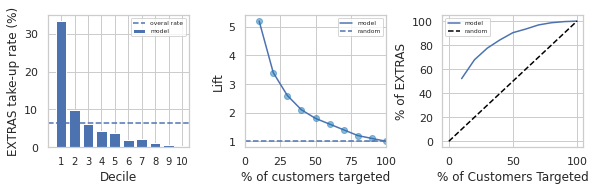

In [215]:
plot_summary_1df(o2extras_summary,'model','DISNEY O2Extras propensity model')

6.37322817862091


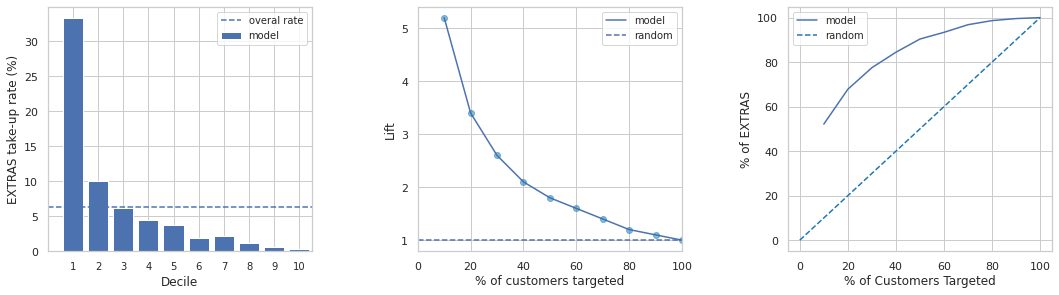

In [216]:
plot_summary_b(o2extras_summary,'model','DISNEY O2Extras propensity model')

In [217]:
feature_names = X_evaluation.columns.to_list()
cat_features = [column for column, dtype in X_evaluation.dtypes.items() if dtype==object]

evaluation_pool = Pool(X_evaluation, y_evaluation, feature_names=feature_names, cat_features=cat_features)

In [218]:
roc_curve = get_roc_curve(model, evaluation_pool)
(fpr , tpr , thresholds ) = roc_curve
roc_auc = auc(fpr , tpr )

print('AUC (Evaluation set) = ', roc_auc)

AUC (Evaluation set) =  0.8412331086547266


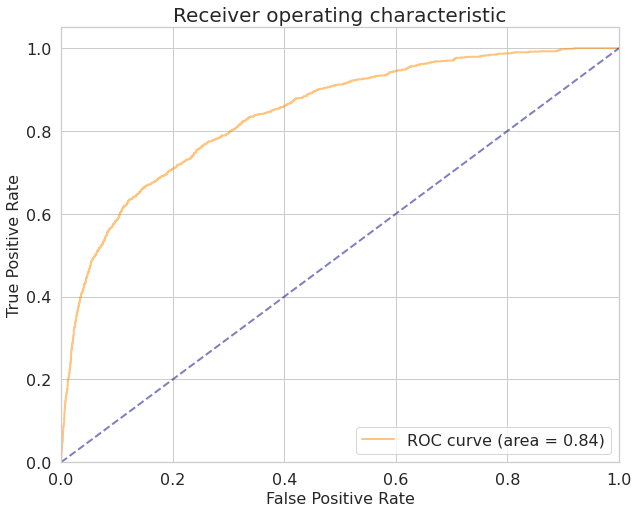

In [219]:
plt.figure(figsize=(10, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.savefig('/home/jupyter/o2extras/outputs/roc_curves.png', bbox_inches='tight')
plt.show()

In [220]:
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

(thresholds, fpr) = get_fpr_curve(curve=roc_curve)
(thresholds, fnr) = get_fnr_curve(curve=roc_curve)

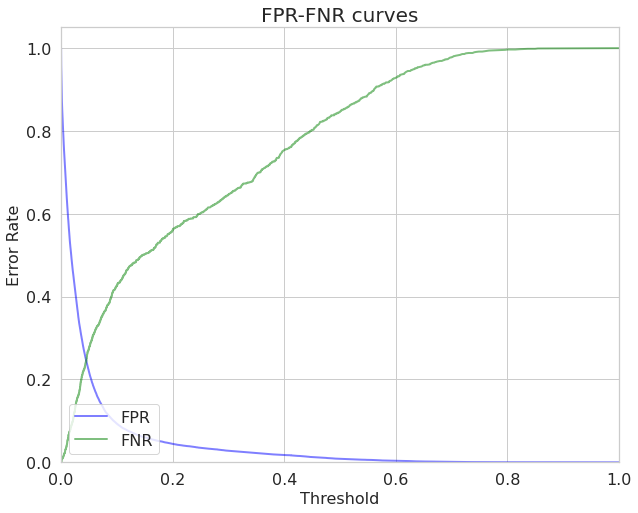

In [221]:
plt.figure(figsize=(10, 8))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.savefig('/home/jupyter/o2extras/outputs/fpr_fnr_curves.png', bbox_inches='tight')
plt.show()

In [222]:
# Calculate the Precision-Recall curve
from sklearn.metrics import precision_recall_curve  

# Create the Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_evaluation, y_pred)



In [223]:
# Calculate F1 scores for different thresholds
f1_scores = 2 * (precision * recall) / (precision + recall)  

In [224]:
# Find the optimal threshold that maximizes F1 score
optimal_threshold = thresholds[np.argmax(f1_scores)]

In [225]:
optimal_threshold

0.16510995345310234

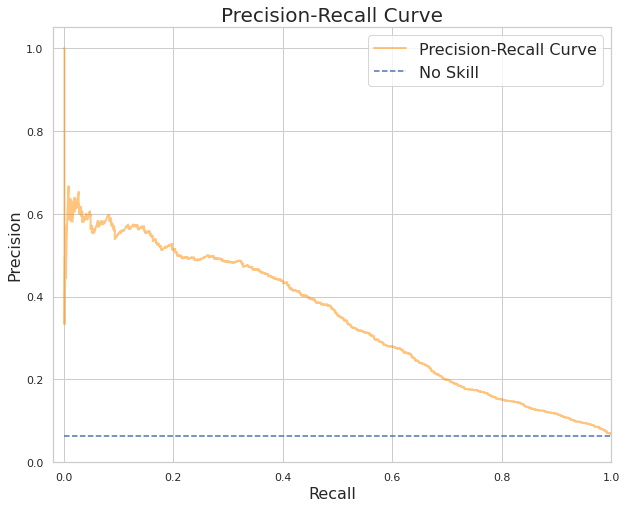

In [226]:
no_skill = len(y_evaluation[y_evaluation==1]) / len(y_evaluation)

plt.figure(figsize = (10,8))
sns.set(font_scale = 1, style = 'whitegrid')
lw = 2
plt.plot(recall, precision, color='darkorange', lw=lw, label='Precision-Recall Curve', alpha=0.5)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.title('Precision-Recall Curve', fontsize=20)
plt.ylabel('Precision', fontsize = 16)
plt.xlabel('Recall', fontsize = 16)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(np.linspace(0,1,6))
plt.yticks(np.linspace(0,1,6))
plt.legend(loc="upper right",fontsize = 16)
plt.grid(True)
plt.savefig('/home/jupyter/o2extras/outputs/precidion-recall_curves.png', bbox_inches='tight')
plt.show()

In [227]:
print(no_skill)

0.0637322817862091


In [228]:
#Best Threshold 
best_th=optimal_threshold
optimal_threshold

0.16510995345310234

In [229]:
def report_performance(y_pred,y_test,Threshold):
    performance = {}
    performance['prec_score'] = precision_score(y_test, y_pred > Threshold)
    performance['rec_score'] = recall_score(y_test, y_pred > Threshold)
    performance['F1_score'] = f1_score(y_test, y_pred > Threshold)
    performance['roc_auc'] = roc_auc_score(y_test, y_pred)
    precision_temp,recall_temp,_=precision_recall_curve(y_test, y_pred)
    performance['roc_precision_recall_curve']=auc(recall_temp,precision_temp)

    return performance

### Performance based on threshold calculated using precision-recall curve/optimal threshold (~0.16)

In [230]:
report_performance(y_pred,y_evaluation,optimal_threshold)

{'prec_score': 0.37816764132553604,
 'rec_score': 0.4866220735785953,
 'F1_score': 0.4255941499085923,
 'roc_auc': 0.8412331086547266,
 'roc_precision_recall_curve': 0.34479477911036105}

Text(48.49999999999999, 0.5, 'Actual')

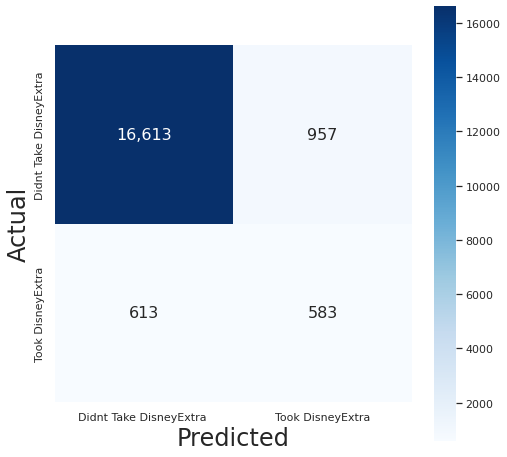

In [231]:
# Confusion Matrix2 BASED optimal_threshold
plt.figure(figsize = (8,8))
#sns.set_context("talk")
#sns.set(font_scale = 2)
ax = sns.heatmap(confusion_matrix(y_evaluation ,y_pred >= optimal_threshold),
            annot_kws = {"size": 16},
            fmt = ',d',
            cmap = 'Blues',
            square = True,
            xticklabels = ['Didnt Take DisneyExtra ','Took DisneyExtra'], 
            yticklabels = ['Didnt Take DisneyExtra','Took DisneyExtra'],
            annot=True
           );
plt.xlabel('Predicted', fontsize = 24)
plt.ylabel('Actual', fontsize = 24)

## Gain Chart

In [232]:
y = pd.DataFrame(y_evaluation) 

gain = pd.DataFrame([i for i in zip(y_pred,y.apply(lambda x: x[0], axis = 1).to_numpy())]).sort_values(0, ascending = False)
gain['cumalative'] = gain[1].cumsum()

cumalative_gain = (gain['cumalative']/max(gain['cumalative']))
observations = np.array(range(gain.shape[0]))/gain.shape[0]
lift = cumalative_gain.div(np.array(range(gain.shape[0]))/gain.shape[0])

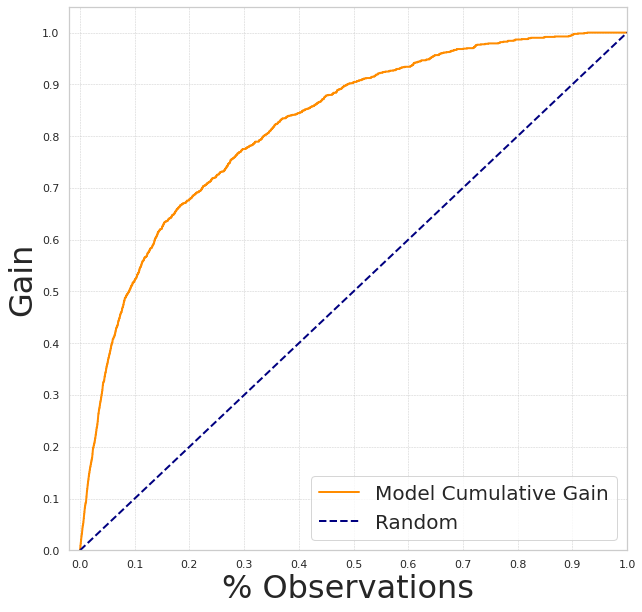

In [233]:
plt.figure(figsize = (10,10))
sns.set(font_scale = 1, style = 'whitegrid')
lw = 2
plt.plot(observations, cumalative_gain, color='darkorange', lw=lw, label='Model Cumulative Gain')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label = 'Random')
plt.ylabel('Gain', fontsize = 32)
plt.xlabel('% Observations', fontsize = 32)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.legend(loc="lower right",fontsize = 20)
plt.grid(True, which='major', linestyle='--', linewidth=0.5, zorder = 0)

## LIFT chart

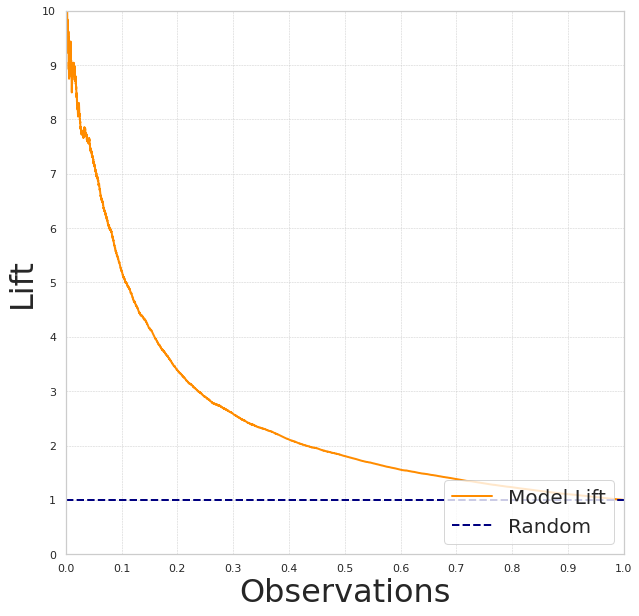

In [234]:
#LIFT chart

plt.figure(figsize = (10,10))
lw = 2
plt.plot(observations, lift, color='darkorange',lw=lw, label='Model Lift')
plt.plot([1, 1], color='navy', lw=lw, linestyle='--', label = 'Random')
plt.ylabel('Lift', fontsize = 32)
plt.xlabel('Observations', fontsize = 32)
plt.xlim([0.05, 1.0])
plt.ylim([0.0, 10])
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,10,11))
plt.legend(loc="lower right",fontsize = 20)
plt.grid(True, which='major', linestyle='--', linewidth=0.5, zorder = 0)

In [235]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_evaluation)
#shap.summary_plot(shap_values, X_evaluation, plot_type="bar", max_display = X_evaluation.shape[1])

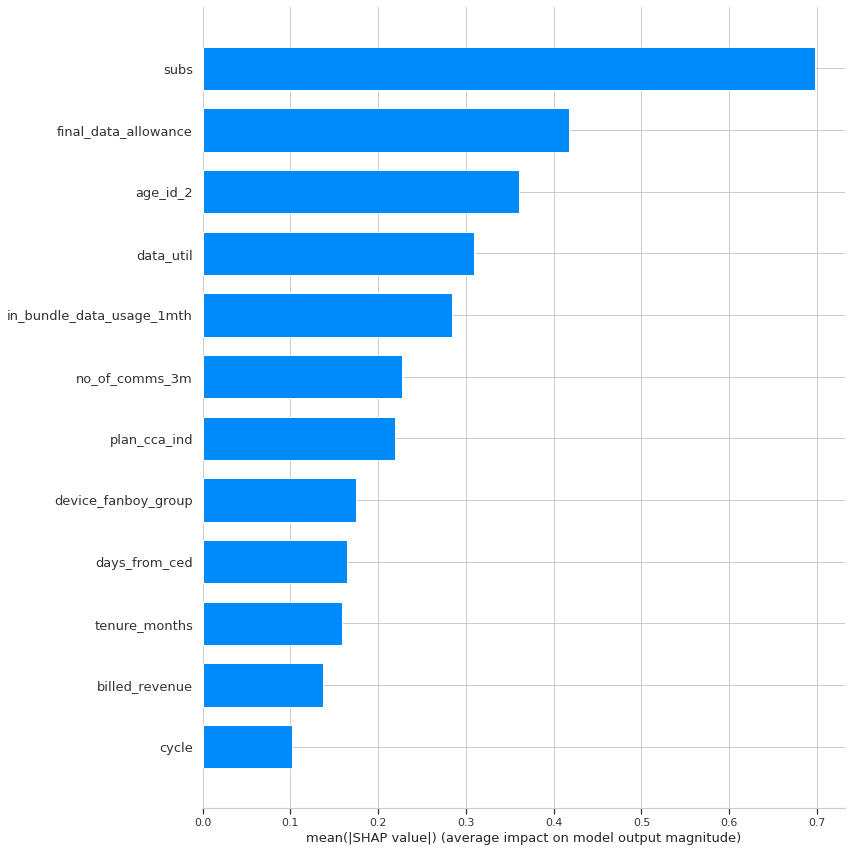

In [236]:
shap.summary_plot(shap_values, X_evaluation, plot_type="bar", max_display = X_evaluation.shape[1], show=False,plot_size=[12,12] )
plt.tight_layout()
plt.savefig('/home/jupyter/o2extras/outputs/shap_summary_plot_bar.png', bbox_inches='tight')
plt.show()

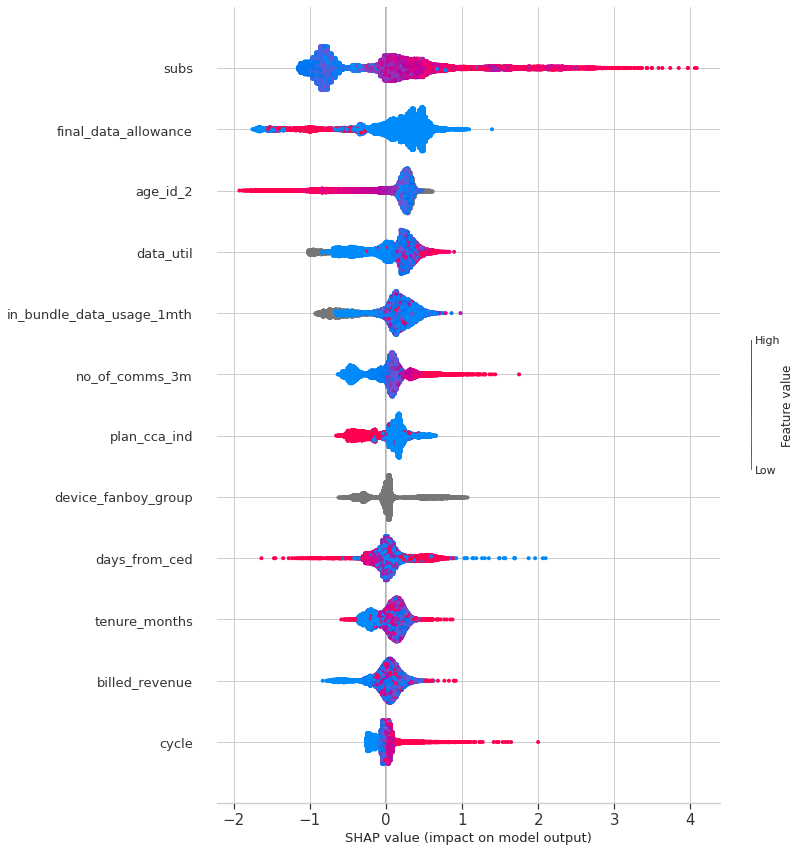

In [237]:
shap.summary_plot(shap_values, X_evaluation, max_display = X_evaluation.shape[1], show=False, plot_size=[12,12] )
plt.xticks(fontsize=15)
plt.tight_layout()
plt.savefig('/home/jupyter/o2extras/outputs/shap_summary_plot.png', bbox_inches='tight')
plt.show()

Shap values are calculated per object, so each object has a set of shap values and there is a baseline value that is the same for all the objects and then there are importances of all features. All these importances they sum to the prediction of the object and your features importances some to prediction. As the real sum of the trees in binary classification is not the probability, so it is not a value between 0-1 , is some like -infinitun, to + infinitum.
For classification models, the base value is equal to the prevalence of the positive class
SHAP values reveal interesting insights into how the input variables are impacting the predictions of the machine learning model, both at the level of individual instances and across the population as a whole.

In [238]:
# Loading results from the json file
with open('/home/jupyter/o2extras/results/rfe-results-20240206-164032.json','r') as f:
    results = json.load(f)

In [239]:
test_pool = Pool(X_evaluation[[results['12']['features']][0]], y_evaluation, feature_names=feature_names, cat_features=cat_features)

In [240]:
shap_values = model.get_feature_importance(
    data=test_pool, 
    
    type='ShapValues'
)
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
print(shap_values.shape)

(18766, 12)


In [241]:
y_pred=model.predict_proba(X_evaluation[[results['12']['features']][0]])[:,1]

In [242]:
print(model.predict_proba([X_evaluation.iloc[1,:]]))

[[0.92554494 0.07445506]]


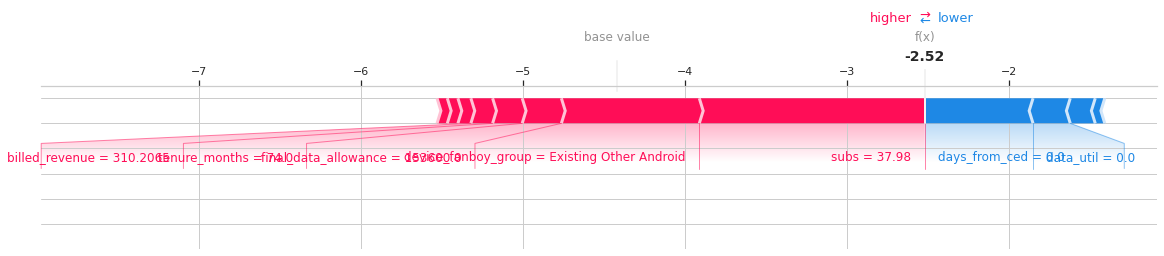

In [243]:
import shap
#shap summary plot plotting


shap.initjs()
shap.force_plot(expected_value, shap_values[1,:], X_evaluation.iloc[1,:],show=False,matplotlib=True).savefig('/home/jupyter/o2extras/outputs/scratch.png',format = "png",dpi = 150,bbox_inches = 'tight')
#plt.savefig('/home/jupyter/o2extras/outputs/shap1.png')
#plt.show()


In [244]:
print(model.predict_proba([X_evaluation.iloc[18763,:]]))

[[0.98543283 0.01456717]]


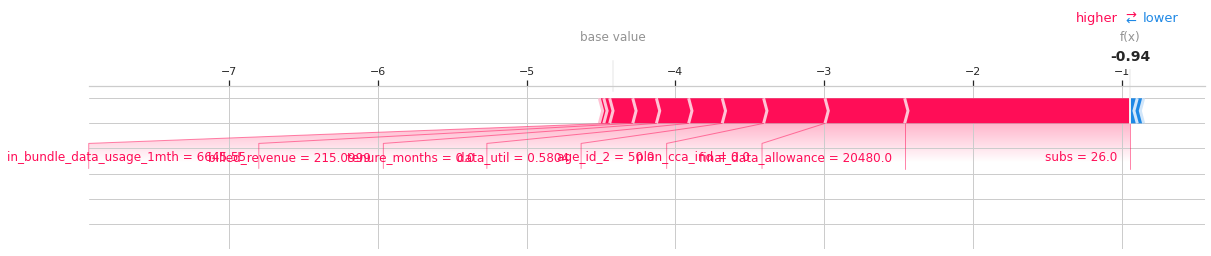

In [245]:
import shap
shap.initjs()
shap.force_plot(expected_value, shap_values[61,:], X_evaluation.iloc[18763,:],show=False,matplotlib=True).savefig('/home/jupyter/o2extras/outputs/scratch2.png',format = "png",dpi = 150,bbox_inches = 'tight')

In [246]:
print(model.predict_proba([X_evaluation.iloc[6,:]]))

[[0.45806122 0.54193878]]


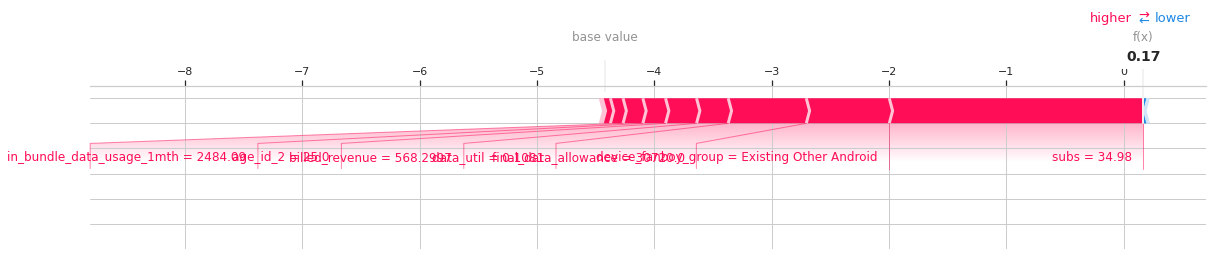

In [247]:
import shap
shap.initjs()
shap.force_plot(expected_value, shap_values[6,:], X_evaluation.iloc[6,:],show=False,matplotlib=True).savefig('/home/jupyter/o2extras/outputs/scratch3.png',format = "png",dpi = 150,bbox_inches = 'tight')

In [248]:
# FOR THE OBJECT ABOVE FEATURE WITH THE MOST POSITIVE INFLUENCE WAS SUBS

In [249]:
print(model.predict_proba([X_evaluation.iloc[741,:]]))

[[0.14731214 0.85268786]]


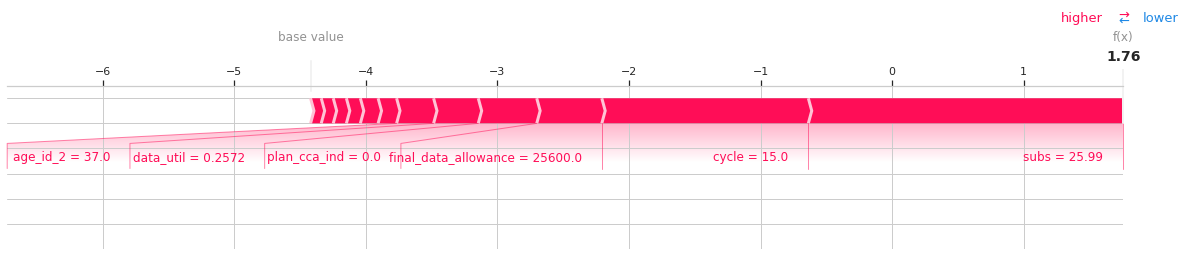

In [250]:
import shap
shap.initjs()
shap.force_plot(expected_value, shap_values[741,:], X_evaluation.iloc[741,:],show=False,matplotlib=True).savefig('/home/jupyter/o2extras/outputs/scratch4.png',format = "png",dpi = 150,bbox_inches = 'tight')

In [251]:
print(model.predict_proba([X_evaluation.iloc[12,:]]))

[[0.85714767 0.14285233]]


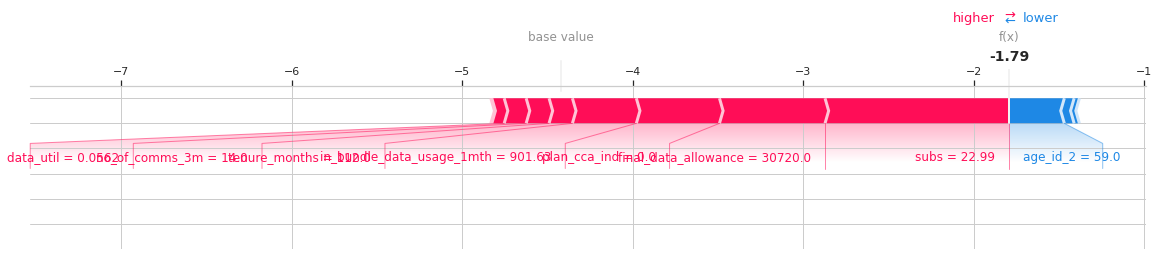

In [252]:
import shap
shap.initjs()
shap.force_plot(expected_value, shap_values[12,:], X_evaluation.iloc[12,:],show=False,matplotlib=True).savefig('/home/jupyter/o2extras/outputs/scratch5.png',format = "png",dpi = 150,bbox_inches = 'tight')

In [253]:
model.predict_proba(X_evaluation)

array([[8.67408408e-01, 1.32591592e-01],
       [9.25544937e-01, 7.44550634e-02],
       [9.48607190e-01, 5.13928099e-02],
       ...,
       [9.85432829e-01, 1.45671707e-02],
       [9.99242573e-01, 7.57427353e-04],
       [9.97468707e-01, 2.53129312e-03]])

In [254]:
evaluation_sumary.head()

,target,pred_prob
0,0,0.132592
1,0,0.074455
2,0,0.051393
3,0,0.005154
4,0,0.043194


In [255]:
evaluation_sumary['decile']=pd.qcut(evaluation_sumary['pred_prob'], 10,labels=range(10,0,-1))
evaluation_sumary

,target,pred_prob,decile
0,0,0.132592,1
1,0,0.074455,2
2,0,0.051393,3
3,0,0.005154,8
4,0,0.043194,3
...,...,...,...
18761,0,0.025122,5
18762,0,0.013034,7
18763,0,0.014567,6
18764,0,0.000757,10


In [256]:
# selecting rows 1st decile
pd.set_option('display.max_rows', 100)
rslt_dec1 = evaluation_sumary.loc[evaluation_sumary['decile'] ==1]
print(rslt_dec1)

       target  pred_prob decile
0           0   0.132592      1
6           0   0.541939      1
12          0   0.142852      1
14          0   0.307979      1
20          1   0.208387      1
...       ...        ...    ...
16869       0   0.285397      1
16879       1   0.270942      1
16888       0   0.199933      1
16900       1   0.295583      1
16910       0   0.216946      1

[1877 rows x 3 columns]


In [257]:
# selecting rows 1st decile
pd.set_option('display.max_rows', 100)
rslt_dec2 = evaluation_sumary.loc[evaluation_sumary['pred_prob'] >=0.7]
print(rslt_dec2)

       target  pred_prob decile
668         0   0.703913      1
741         1   0.852688      1
1316        1   0.717687      1
1346        0   0.717123      1
1483        0   0.809438      1
1808        0   0.700926      1
1849        0   0.846528      1
1954        1   0.818593      1
1967        1   0.723901      1
2112        1   0.708116      1
2218        1   0.723920      1
2300        0   0.704210      1
2459        1   0.754721      1
2614        0   0.804302      1
3263        1   0.711447      1
3265        1   0.763232      1
3293        1   0.703739      1
3517        0   0.883158      1
3533        1   0.795527      1
3588        1   0.738463      1
3772        1   0.827073      1
4064        1   0.770261      1
4616        1   0.763359      1
4643        1   0.705961      1
4840        1   0.701245      1
5184        1   0.716953      1
5226        1   0.701941      1
6192        0   0.721482      1
6232        0   0.750892      1
6249        0   0.735999      1
6361    

In [258]:
# selecting rows 1st decile
pd.set_option('display.max_rows', 100)
rslt_highprob = evaluation_sumary.loc[evaluation_sumary['pred_prob'] >=0.5]
print(rslt_highprob)

       target  pred_prob decile
6           0   0.541939      1
28          0   0.559301      1
70          0   0.574111      1
73          0   0.517305      1
98          1   0.555186      1
...       ...        ...    ...
15760       0   0.691623      1
15778       1   0.528952      1
16114       0   0.628981      1
16366       0   0.555193      1
16761       1   0.536932      1

[330 rows x 3 columns]


In [259]:

print(rslt_dec1['pred_prob'].min())

0.12793732078133976


In [260]:
print(rslt_dec1['pred_prob'].max())

0.8938589733987916


In [261]:
print(list(eval_df.columns))


['usi', 'target', 'subs', 'final_data_allowance', 'days_from_ced', 'no_of_comms_3m', 'in_bundle_data_usage_1mth', 'device_fanboy_group', 'plan_cca_ind', 'billed_revenue', 'age_id_2', 'cycle', 'data_util', 'tenure_months']


In [262]:
evaluation_sumary['usi']=eval_df['usi']

In [263]:
evaluation_sumary.head()

,target,pred_prob,decile,usi
0,0,0.132592,1,-956689181
1,0,0.074455,2,-480748844
2,0,0.051393,3,-996043646
3,0,0.005154,8,-976381590
4,0,0.043194,3,-948762147


In [ ]:
dfgrpdecile =evaluation_sumary.groupby('decile').agg(no_of_customers=('pred_prob','count'))
dfgrpdecile

,no_of_customers
decile,
10,1877
9,1877
8,1876
7,1877
6,1876
5,1877
4,1876
3,1877
2,1876


In [106]:
#df_temp = evaluation_sumary.groupby('decile').agg(no_of_customers=('pred_prob','count'),).reset_index(drop = False)
#df_temp

In [108]:
### other checks /views

In [267]:
## final_data_allowance

In [268]:
%%bigquery

  SELECT
  PERCENTILE_CONT(final_data_allowance, 0) OVER() AS min,
  PERCENTILE_CONT(final_data_allowance, 0.25) OVER() AS _25th,
  PERCENTILE_CONT(final_data_allowance, 0.5) OVER() AS median,
  PERCENTILE_CONT(final_data_allowance, 0.75) OVER() AS _75th,
  PERCENTILE_CONT(final_data_allowance, 1) OVER() AS max
FROM
  prj-vo-aa-p-data-science-exp.jorquec.O2extrasdisneyM4
  where target=1
LIMIT
  1

Query complete after 0.00s: 100% 1/1 [00:00<00:00, 1559.22query/s]
Downloading: 100% 1/1 [00:00<00:00,  1.06rows/s]


,min,_25th,median,_75th,max
0,250.0,15360.0,30720.0,102400.0,99999999.0


array([[<AxesSubplot:title={'center':'final_data_allowance'}>]],
      dtype=object)

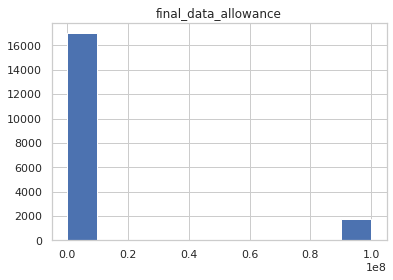

In [269]:
df.hist(column='final_data_allowance')

array([[<AxesSubplot:title={'center':'subs'}>]], dtype=object)

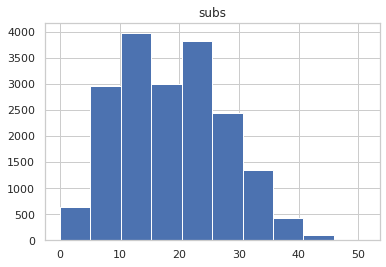

In [270]:
df.hist(column='subs')

In [271]:
# Create data
counts, bins = np.histogram(df['subs'])

print(counts)

[ 646 2964 3974 3007 3826 2452 1358  422  105   12]


In [272]:
print(bins)

[ 0.     5.097 10.194 15.291 20.388 25.485 30.582 35.679 40.776 45.873
 50.97 ]


In [273]:
# Sample size
n = len(df)

print(f'Sample size, n = {n}')

Sample size, n = 18766


In [274]:
intervals = [f'{int(v)} to {int(bins[i +1])}' for i, v in enumerate(bins[:-1])]
dct = {
    'Interval (bin)': intervals,
    'Frequency': counts,
    '%': (counts / n * 100).round(1),
    'Cumulative %': (counts / n * 100).cumsum().round(1)
}
frequency_distribution = pd.DataFrame(dct)

print(frequency_distribution)

  Interval (bin)  Frequency     %  Cumulative %
0         0 to 5        646   3.4           3.4
1        5 to 10       2964  15.8          19.2
2       10 to 15       3974  21.2          40.4
3       15 to 20       3007  16.0          56.4
4       20 to 25       3826  20.4          76.8
5       25 to 30       2452  13.1          89.9
6       30 to 35       1358   7.2          97.1
7       35 to 40        422   2.2          99.4
8       40 to 45        105   0.6          99.9
9       45 to 50         12   0.1         100.0


In [277]:

# selecting rows based on condition , get rid off unlimited  data
rslt_df = df[df['final_data_allowance'] < 999999] 
rslt_df.shape

(17004, 147)

In [278]:
print(rslt_df['final_data_allowance'].value_counts(dropna=False))

5120.0      2642
153600.0    1815
15360.0     1796
6144.0      1708
30720.0     1260
20480.0     1257
25600.0     1118
76800.0      967
2048.0       834
102400.0     730
51200.0      653
256000.0     620
1024.0       457
4096.0       440
128000.0     339
3072.0       205
122880.0     102
500.0         27
10240.0       17
250.0         11
40960.0        4
204800.0       2
Name: final_data_allowance, dtype: int64


In [279]:
df.groupby(["target","contract_type"])["final_data_allowance"].count()

target  contract_type  
0       Handset Refresh    5124
        Simo               7940
        Unknown            4499
1       Handset Refresh     319
        Simo                741
        Unknown             136
Name: final_data_allowance, dtype: int64

In [280]:
print(list(df.columns))

['usi', 'cycle', 'days_from_ced', 'ooc', 'resign_fanboy_group', 'channel_l1', 'sim_only_ind', 'mins_allowance', 'term', 'tenure_months', 'tenure_desc', 'time_on_handset', 'age_id_2', 'spend_cap_level', 'contract_type', 'refresh', 'flex_refresh_flag', 'first_recent_channel', 'second_recent_channel', 'third_recent_channel', 'cs_int_flag', 'digital_int_flag', 'wc_int_flag', 'no_of_comms_3m', 'no_of_comms_6m', 'ecn_sent_flag_l1m', 'wifi', 'device_fanboy_group', 'subs', 'pac_request_l1m', 'credit_band', 'multiple_mpn_flag', 'os_desc', 'device_os', 'iphone', 'vendor_desc_2', 'hs_flag', 'simo_flag', 'total_isrl_browsing_time_l3m', 'isrl_browsing_time_cat', 'domestic_data_costs', 'avg_dom_data_costs', 'ch_dom_data_costs', 'no_of_cells_used', 'avg_tot_ic_cost', 'ch_tot_ic_cost', 'total_interconnect_cost', 'arpu', 'airtime_margin', 'avg_arpu', 'avg_airtime_margin', 'ch_arpu', 'ch_airtime_margin', 'revenue_amount', 'ch_billed_revenue', 'billed_revenue', 'avg_billed_revenue', 'domestic_data_usage'

(1024.0, 256000.0)

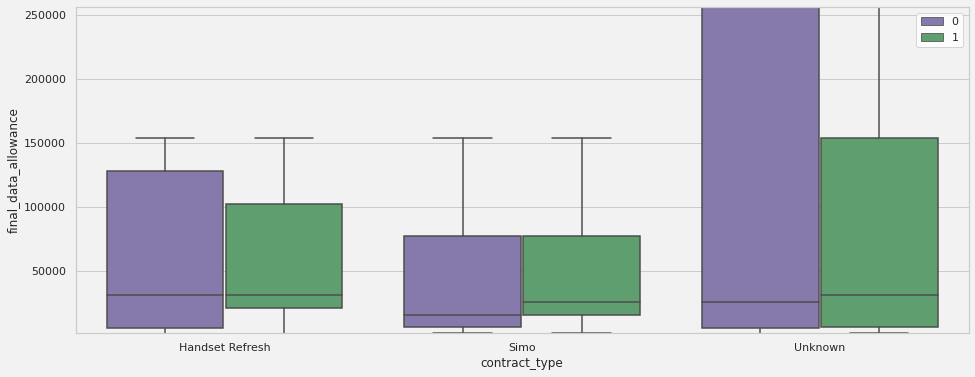

In [281]:
#final_data_allowance
#Draw a nested boxplot 
fig = plt.figure(figsize = (16,6),facecolor= '#F2F2F2')
ax = fig.add_subplot(111)
ax.set_facecolor('#F2F2F2')
 
#fig.set_facecolor('#F2F2F2')
g=sns.boxplot(x="contract_type", y="final_data_allowance",
            hue="target", palette=["m", "g"],
            data=df,
            showfliers = False,
            showmeans= True
            )
medians = df.groupby(['contract_type'])['final_data_allowance'].median()
vertical_offset = df['final_data_allowance'].median()* 0.05  # offset from median for display
 
#for xtick in g.get_xticks():
#    g.text(xtick,medians[xtick] + vertical_offset,medians[xtick],
#            horizontalalignment='center',size='x-small',color='w',weight='semibold')
 
plt.legend(loc='upper right')
#plt.show()
g.set_ylim(1024,256000)
#g.despine(offset=10, trim=True)

(0.0, 50.0)

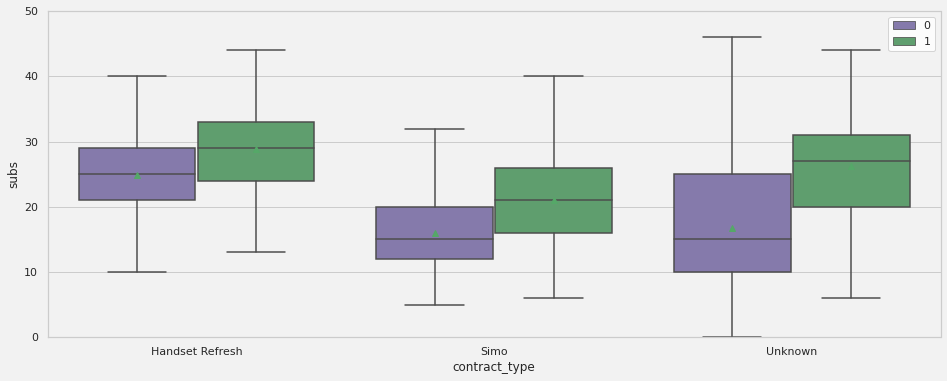

In [282]:
#final_data_allowance
#Draw a nested boxplot 
fig = plt.figure(figsize = (16,6),facecolor= '#F2F2F2')
ax = fig.add_subplot(111)
ax.set_facecolor('#F2F2F2')
 
#fig.set_facecolor('#F2F2F2')
g=sns.boxplot(x="contract_type", y="subs",
            hue="target", palette=["m", "g"],
            data=df,
            showfliers = False,
            showmeans= True
            )
medians = df.groupby(['contract_type'])['subs'].median()
vertical_offset = df['subs'].median()* 0.05  # offset from median for display
 
#for xtick in g.get_xticks():
#    g.text(xtick,medians[xtick] + vertical_offset,medians[xtick],
#            horizontalalignment='center',size='x-small',color='w',weight='semibold')
 
plt.legend(loc='upper right')
#plt.show()
g.set_ylim(0,50)
#g.despine(offset=10, trim=True)

(0.0, 50.0)

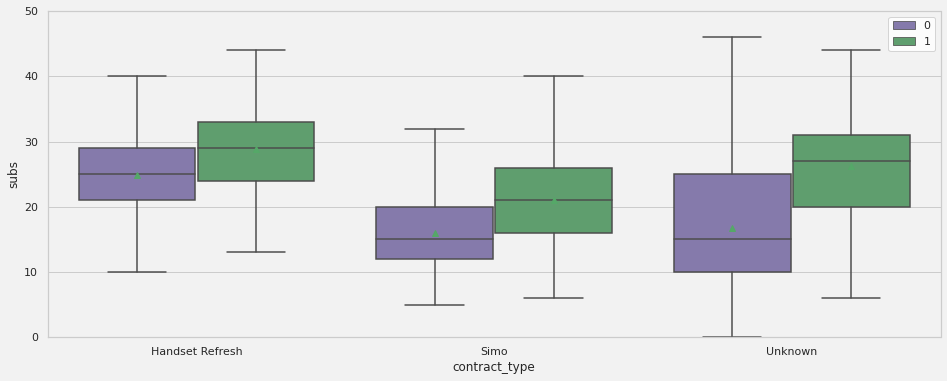

In [283]:
#contract type, target and subs
#Draw a nested boxplot 
fig = plt.figure(figsize = (16,6),facecolor= '#F2F2F2')
ax = fig.add_subplot(111)
ax.set_facecolor('#F2F2F2')
 
#fig.set_facecolor('#F2F2F2')
g=sns.boxplot(x="contract_type", y="subs",
            hue="target", palette=["m", "g"],
            data=df,
            showfliers = False,
            showmeans= True
            )
medians = df.groupby(['contract_type', 'target'])['subs'].median()
vertical_offset = df['subs'].median()* 0.05  # offset from median for display
 
#for xtick in g.get_xticks():
#    g.text(xtick,medians[xtick] + vertical_offset,medians[xtick],
#            horizontalalignment='center',size='x-small',color='w',weight='semibold')
 
plt.legend(loc='upper right')
#plt.show()
g.set_ylim(0,50)
#g.despine(offset=10, trim=True)

(1024.0, 350000.0)

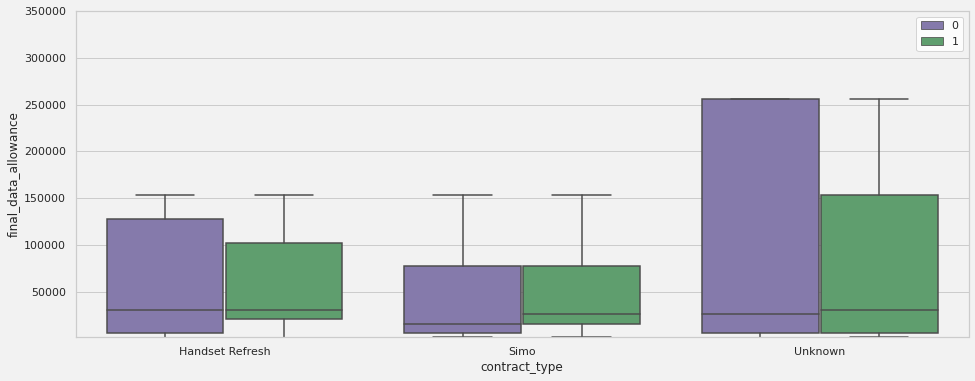

In [284]:
#contract type, target and final_data_allowance 
#Draw a nested boxplot 
fig = plt.figure(figsize = (16,6),facecolor= '#F2F2F2')
ax = fig.add_subplot(111)
ax.set_facecolor('#F2F2F2')
 
#fig.set_facecolor('#F2F2F2')
g=sns.boxplot(x="contract_type", y="final_data_allowance",
            hue="target", palette=["m", "g"],
            data=df,
            showfliers = False,
            showmeans= True
            )
medians = df.groupby(['contract_type', 'target'])['final_data_allowance'].median()
vertical_offset = df['final_data_allowance'].median()* 0.05  # offset from median for display
 
#for xtick in g.get_xticks():
#    g.text(xtick,medians[xtick] + vertical_offset,medians[xtick],
#            horizontalalignment='center',size='x-small',color='w',weight='semibold')
 
plt.legend(loc='upper right')
#plt.show()
g.set_ylim(1024,350000)
#g.despine(offset=10, trim=True)

In [285]:
df[['contract_type']].value_counts(normalize=True).reset_index(name='count')

,contract_type,count
0,Simo,0.462592
1,Handset Refresh,0.290046
2,Unknown,0.247362


In [286]:
df['days_from_ced'].describe()

count    18766.000000
mean      -733.611318
std        298.655283
min      -1459.000000
25%      -1073.000000
50%       -713.000000
75%       -527.000000
max          0.000000
Name: days_from_ced, dtype: float64

(-1450.0, 10.0)

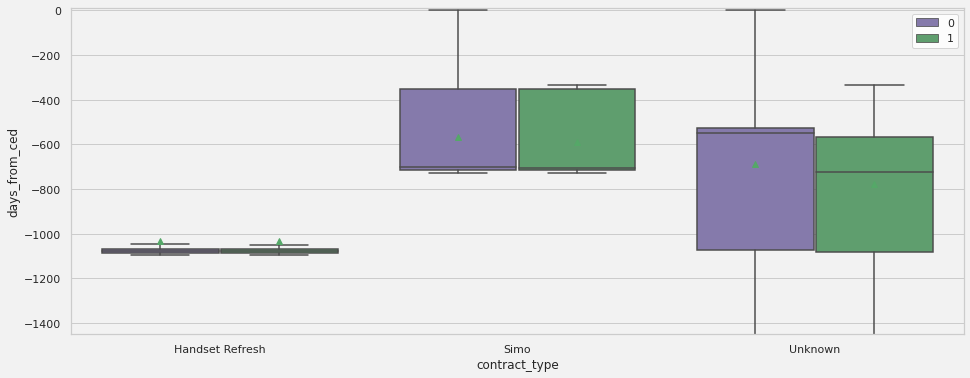

In [287]:
#contract type, target and days_from_ced
#Draw a nested boxplot 
fig = plt.figure(figsize = (16,6),facecolor= '#F2F2F2')
ax = fig.add_subplot(111)
ax.set_facecolor('#F2F2F2')
 
#fig.set_facecolor('#F2F2F2')
g=sns.boxplot(x="contract_type", y="days_from_ced",
            hue="target", palette=["m", "g"],
            data=df,
            showfliers = False,
            showmeans= True
            )
medians = df.groupby(['contract_type', 'target'])['days_from_ced'].median()
vertical_offset = df['days_from_ced'].median()* 0.05  # offset from median for display
 
#for xtick in g.get_xticks():
#    g.text(xtick,medians[xtick] + vertical_offset,medians[xtick],
#            horizontalalignment='center',size='x-small',color='w',weight='semibold')
 
plt.legend(loc='upper right')
#plt.show()
g.set_ylim(-1450,10)
#g.despine(offset=10, trim=True)

In [288]:
df['no_of_comms_3m'].describe()

count    18756.000000
mean         8.576989
std         12.739039
min          0.000000
25%          2.000000
50%          6.000000
75%         12.000000
max        683.000000
Name: no_of_comms_3m, dtype: float64

(0.0, 30.0)

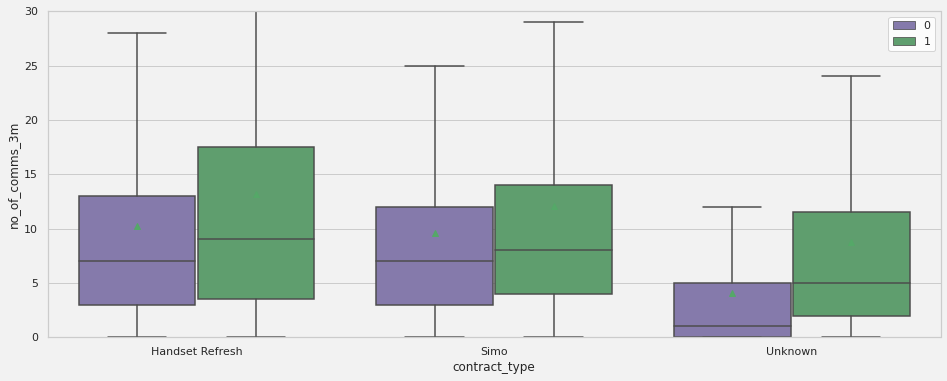

In [289]:
#contract type, target and no_of_comms_3m
#Draw a nested boxplot 
fig = plt.figure(figsize = (16,6),facecolor= '#F2F2F2')
ax = fig.add_subplot(111)
ax.set_facecolor('#F2F2F2')
 
#fig.set_facecolor('#F2F2F2')
g=sns.boxplot(x="contract_type", y="no_of_comms_3m",
            hue="target", palette=["m", "g"],
            data=df,
            showfliers = False,
            showmeans= True
            )
medians = df.groupby(['contract_type', 'target'])['no_of_comms_3m'].median()
vertical_offset = df['no_of_comms_3m'].median()* 0.05  # offset from median for display
 
#for xtick in g.get_xticks():
#    g.text(xtick,medians[xtick] + vertical_offset,medians[xtick],
#            horizontalalignment='center',size='x-small',color='w',weight='semibold')
 
plt.legend(loc='upper right')
#plt.show()
g.set_ylim(0,30)
#g.despine(offset=10, trim=True)

In [290]:
df['in_bundle_data_usage_1mth'].describe()

count    1.564000e+04
mean     8.743185e+03
std      2.819457e+04
min      0.000000e+00
25%      7.289750e+02
50%      2.738650e+03
75%      8.046615e+03
max      1.108337e+06
Name: in_bundle_data_usage_1mth, dtype: float64

(0.0, 30000.0)

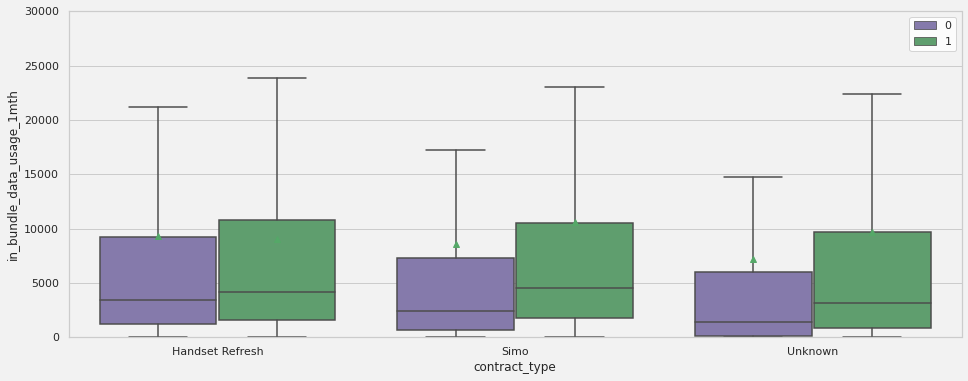

In [291]:
#contract type, target and in_bundle_data_usage_1mth
#Draw a nested boxplot 
fig = plt.figure(figsize = (16,6),facecolor= '#F2F2F2')
ax = fig.add_subplot(111)
ax.set_facecolor('#F2F2F2')
 
#fig.set_facecolor('#F2F2F2')
g=sns.boxplot(x="contract_type", y="in_bundle_data_usage_1mth",
            hue="target", palette=["m", "g"],
            data=df,
            showfliers = False,
            showmeans= True
            )
medians = df.groupby(['contract_type', 'target'])['in_bundle_data_usage_1mth'].median()
vertical_offset = df['in_bundle_data_usage_1mth'].median()* 0.05  # offset from median for display
 
#for xtick in g.get_xticks():
#    g.text(xtick,medians[xtick] + vertical_offset,medians[xtick],
#            horizontalalignment='center',size='x-small',color='w',weight='semibold')
 
plt.legend(loc='upper right')
#plt.show()
g.set_ylim(0,30000)
#g.despine(offset=10, trim=True)

In [292]:
df['plan_cca_ind'].describe()

count    18766.000000
mean         0.368645
std          0.482450
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: plan_cca_ind, dtype: float64

(0.0, 1.5)

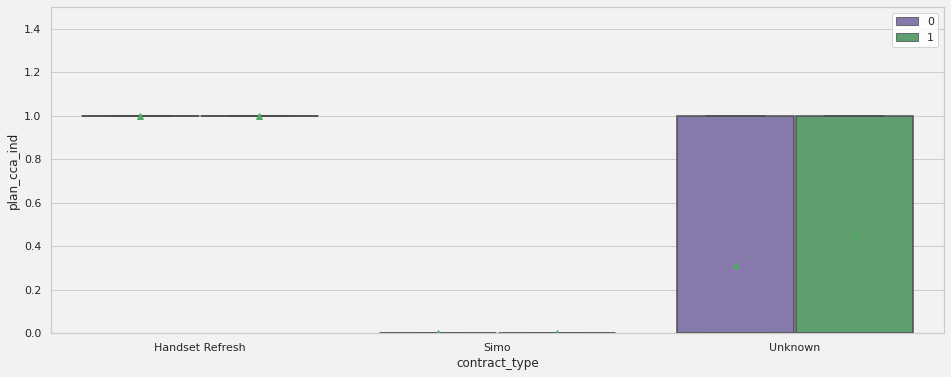

In [293]:
#contract type, target and in_bundle_data_usage_1mth
#Draw a nested boxplot 
fig = plt.figure(figsize = (16,6),facecolor= '#F2F2F2')
ax = fig.add_subplot(111)
ax.set_facecolor('#F2F2F2')
 
#fig.set_facecolor('#F2F2F2')
g=sns.boxplot(x="contract_type", y="plan_cca_ind",
            hue="target", palette=["m", "g"],
            data=df,
            showfliers = False,
            showmeans= True
            )
medians = df.groupby(['contract_type', 'target'])['plan_cca_ind'].median()
vertical_offset = df['plan_cca_ind'].median()* 0.05  # offset from median for display
 
#for xtick in g.get_xticks():
#    g.text(xtick,medians[xtick] + vertical_offset,medians[xtick],
#            horizontalalignment='center',size='x-small',color='w',weight='semibold')
 
plt.legend(loc='upper right')
#plt.show()
g.set_ylim(0,1.5)
#g.despine(offset=10, trim=True)

In [294]:
df['billed_revenue'].describe()

count    18766.000000
mean       270.456249
std        242.571042
min      -1052.430000
25%        106.236150
50%        184.562100
75%        381.992200
max       5009.534100
Name: billed_revenue, dtype: float64

(-200.0, 900.0)

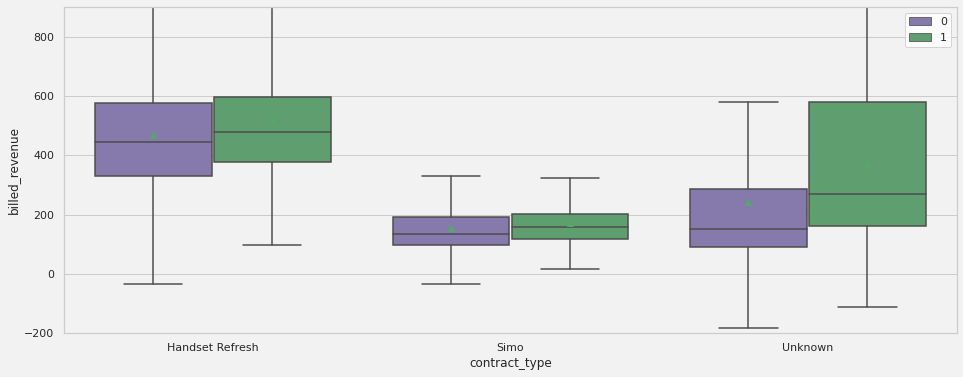

In [295]:
#contract type, target and billed_revenue
#Draw a nested boxplot 
fig = plt.figure(figsize = (16,6),facecolor= '#F2F2F2')
ax = fig.add_subplot(111)
ax.set_facecolor('#F2F2F2')
 
#fig.set_facecolor('#F2F2F2')
g=sns.boxplot(x="contract_type", y="billed_revenue",
            hue="target", palette=["m", "g"],
            data=df,
            showfliers = False,
            showmeans= True
            )
medians = df.groupby(['contract_type', 'target'])['billed_revenue'].median()
vertical_offset = df['billed_revenue'].median()* 0.05  # offset from median for display
 
#for xtick in g.get_xticks():
#    g.text(xtick,medians[xtick] + vertical_offset,medians[xtick],
#            horizontalalignment='center',size='x-small',color='w',weight='semibold')
 
plt.legend(loc='upper right')
#plt.show()
g.set_ylim(-200,900)
#g.despine(offset=10, trim=True)

In [296]:
df['age_id_2'].describe()

count    14451.000000
mean        48.590271
std         16.056429
min         18.000000
25%         35.000000
50%         47.000000
75%         60.000000
max         98.000000
Name: age_id_2, dtype: float64

array([[<AxesSubplot:title={'center':'age_id_2'}>]], dtype=object)

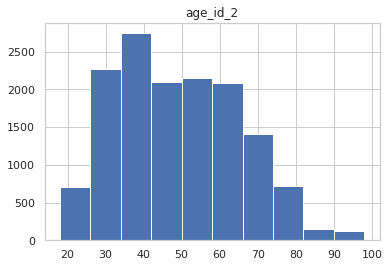

In [297]:
df.hist(column='age_id_2')

(18.0, 100.0)

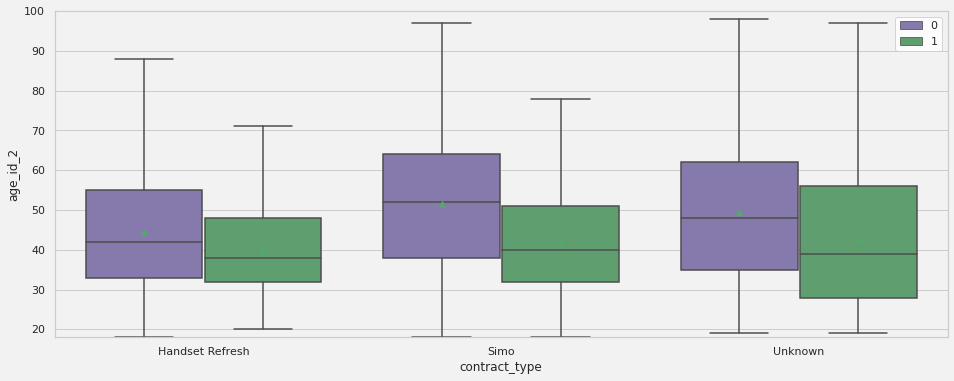

In [298]:
#contract type, target and age_id_2
#Draw a nested boxplot 
fig = plt.figure(figsize = (16,6),facecolor= '#F2F2F2')
ax = fig.add_subplot(111)
ax.set_facecolor('#F2F2F2')
 
#fig.set_facecolor('#F2F2F2')
g=sns.boxplot(x="contract_type", y="age_id_2",
            hue="target", palette=["m", "g"],
            data=df,
            showfliers = False,
            showmeans= True
            )
medians = df.groupby(['contract_type', 'target'])['age_id_2'].median()
vertical_offset = df['age_id_2'].median()* 0.05  # offset from median for display
 
#for xtick in g.get_xticks():
#    g.text(xtick,medians[xtick] + vertical_offset,medians[xtick],
#            horizontalalignment='center',size='x-small',color='w',weight='semibold')
 
plt.legend(loc='upper right')
#plt.show()
g.set_ylim(18,100)
#g.despine(offset=10, trim=True)

In [299]:
df['cycle'].describe()

count    18752.000000
mean         3.948645
std          2.626721
min          1.000000
25%          1.000000
50%          4.000000
75%          6.000000
max         20.000000
Name: cycle, dtype: float64

(0.0, 15.0)

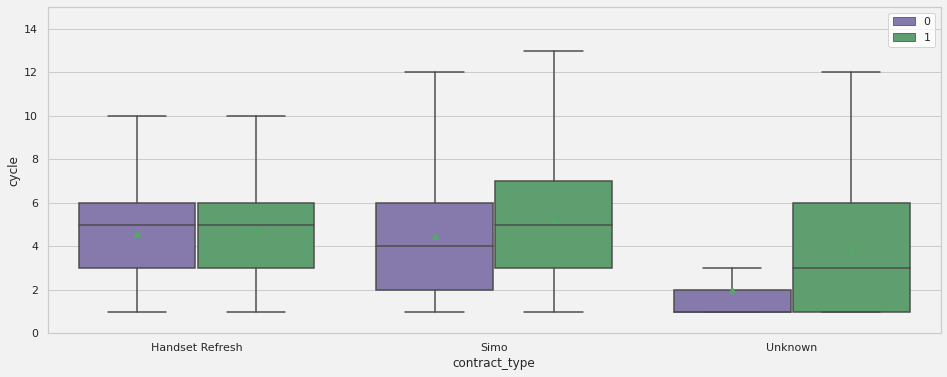

In [300]:
#contract type, target and cycle
#Draw a nested boxplot 
fig = plt.figure(figsize = (16,6),facecolor= '#F2F2F2')
ax = fig.add_subplot(111)
ax.set_facecolor('#F2F2F2')
 
#fig.set_facecolor('#F2F2F2')
g=sns.boxplot(x="contract_type", y="cycle",
            hue="target", palette=["m", "g"],
            data=df,
            showfliers = False,
            showmeans= True
            )
medians = df.groupby(['contract_type', 'target'])['cycle'].median()
vertical_offset = df['cycle'].median()* 0.05  # offset from median for display
 
#for xtick in g.get_xticks():
#    g.text(xtick,medians[xtick] + vertical_offset,medians[xtick],
#            horizontalalignment='center',size='x-small',color='w',weight='semibold')
 
plt.legend(loc='upper right')
#plt.show()
g.set_ylim(0,15)
#g.despine(offset=10, trim=True)

In [301]:
df['data_util'].describe()

count    17862.000000
mean         0.223796
std          0.292240
min          0.000000
25%          0.007300
50%          0.097400
75%          0.309175
max          1.000000
Name: data_util, dtype: float64

(0.0, 1.0)

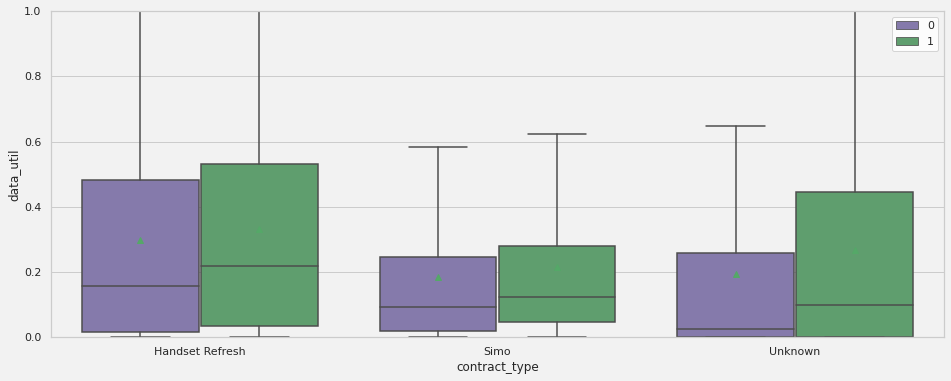

In [302]:
#contract type, target and data_util
#Draw a nested boxplot 
fig = plt.figure(figsize = (16,6),facecolor= '#F2F2F2')
ax = fig.add_subplot(111)
ax.set_facecolor('#F2F2F2')
 
#fig.set_facecolor('#F2F2F2')
g=sns.boxplot(x="contract_type", y="data_util",
            hue="target", palette=["m", "g"],
            data=df,
            showfliers = False,
            showmeans= True
            )
medians = df.groupby(['contract_type', 'target'])['data_util'].median()
vertical_offset = df['data_util'].median()* 0.05  # offset from median for display
 
#for xtick in g.get_xticks():
#    g.text(xtick,medians[xtick] + vertical_offset,medians[xtick],
#            horizontalalignment='center',size='x-small',color='w',weight='semibold')
 
plt.legend(loc='upper right')
#plt.show()
g.set_ylim(0,1)
#g.despine(offset=10, trim=True)

In [303]:
df['tenure_months'].describe()

count    18766.000000
mean        77.527337
std         70.810954
min          0.000000
25%          0.000000
50%         66.000000
75%        129.000000
max        326.000000
Name: tenure_months, dtype: float64

(0.0, 400.0)

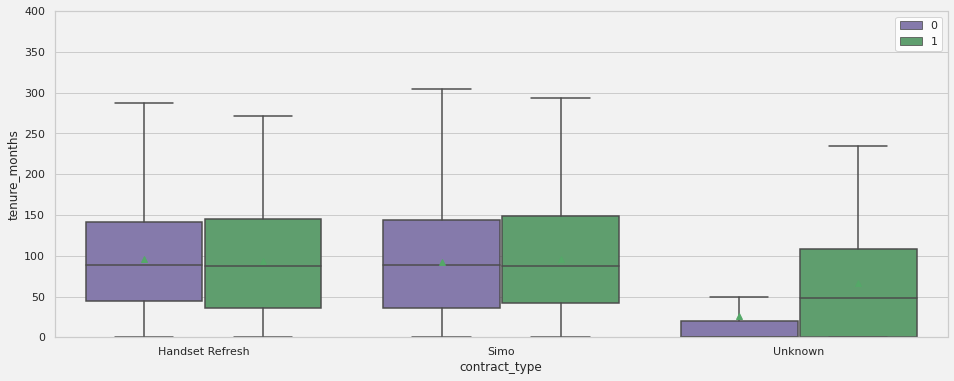

In [304]:
#contract type, target and tenure_months
#Draw a nested boxplot 
fig = plt.figure(figsize = (16,6),facecolor= '#F2F2F2')
ax = fig.add_subplot(111)
ax.set_facecolor('#F2F2F2')
 
#fig.set_facecolor('#F2F2F2')
g=sns.boxplot(x="contract_type", y="tenure_months",
            hue="target", palette=["m", "g"],
            data=df,
            showfliers = False,
            showmeans= True
            )
medians = df.groupby(['contract_type', 'target'])['tenure_months'].median()
vertical_offset = df['tenure_months'].median()* 0.05  # offset from median for display
 
#for xtick in g.get_xticks():
#    g.text(xtick,medians[xtick] + vertical_offset,medians[xtick],
#            horizontalalignment='center',size='x-small',color='w',weight='semibold')
 
plt.legend(loc='upper right')
#plt.show()
g.set_ylim(0,400)
#g.despine(offset=10, trim=True)

In [305]:
['subs',
 'final_data_allowance',
 'days_from_ced',
 'no_of_comms_3m',
 'in_bundle_data_usage_1mth',
 'device_fanboy_group',
 'plan_cca_ind',
 'billed_revenue',
 'age_id_2',
 'cycle',
 'data_util',
 'tenure_months']

['subs',
 'final_data_allowance',
 'days_from_ced',
 'no_of_comms_3m',
 'in_bundle_data_usage_1mth',
 'device_fanboy_group',
 'plan_cca_ind',
 'billed_revenue',
 'age_id_2',
 'cycle',
 'data_util',
 'tenure_months']

<AxesSubplot:xlabel='subs', ylabel='data_util'>

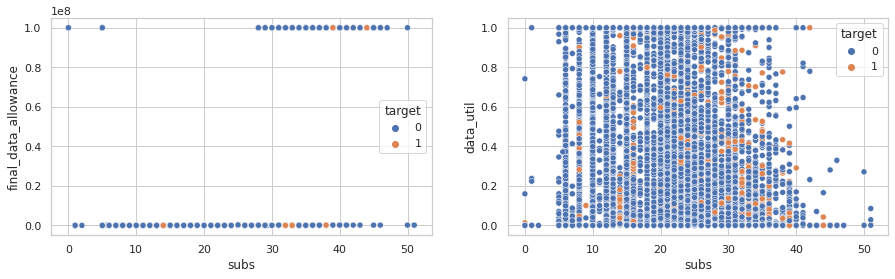

In [306]:
fig, axs = plt.subplots(1,2, figsize=(15, 4))
sns.scatterplot(x=df['subs'], y = df['final_data_allowance'],hue = df['target'], ax=axs[0])
sns.scatterplot(x=df['subs'], y = df['data_util'],hue = df['target'], ax=axs[1])


<AxesSubplot:xlabel='final_data_allowance', ylabel='final_data_allowance'>

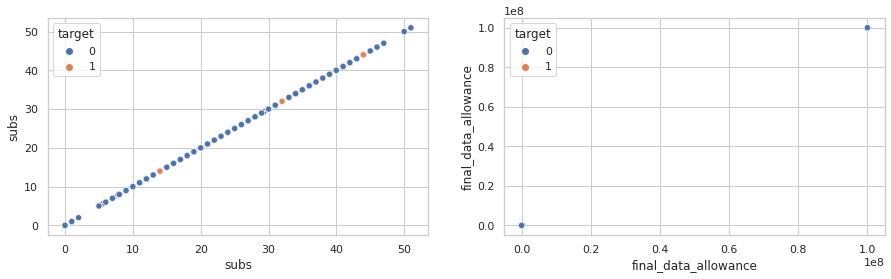

In [307]:
fig, axs = plt.subplots(1,2, figsize=(15, 4))
sns.scatterplot(x=df['subs'], y = df['subs'],hue = df['target'], ax=axs[0])
sns.scatterplot(x=df['final_data_allowance'], y = df['final_data_allowance'],hue = df['target'], ax=axs[1])


<AxesSubplot:xlabel='days_from_ced', ylabel='no_of_comms_3m'>

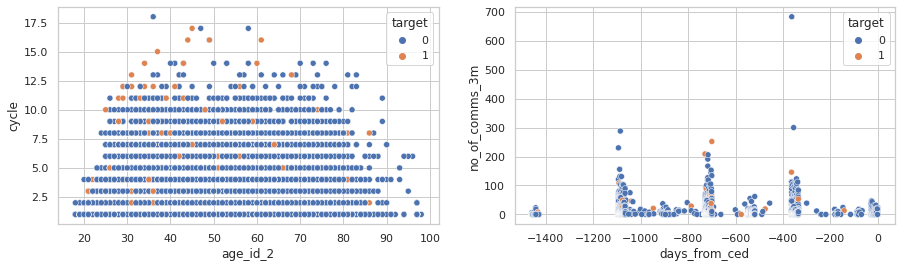

In [308]:
fig, axs = plt.subplots(1,2, figsize=(15, 4))
sns.scatterplot(x=df['age_id_2'], y = df['cycle'],hue = df['target'], ax=axs[0])
sns.scatterplot(x=df['days_from_ced'], y = df['no_of_comms_3m'],hue = df['target'], ax=axs[1])